# Dataset Prepration


Data: https://universe.roboflow.com/universiti-malaysia-pahang-qcvas/objectdetection-ngxjp/dataset/5#

In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="ZkNMlNnyIa2y7w8zGWMS")
project = rf.workspace("universiti-malaysia-pahang-qcvas").project("objectdetection-ngxjp")
version = project.version(5)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to objectdetection-5 in yolov5pytorch:: 100%|██████████| 5220/5220 [00:00<00:00, 7119.24it/s]


In [5]:
import os
import json

# annotations_dir = "/content/objectdetection-5/train/labels"
# output_json_file = "/content/objectdetection-5/train/images/train_annotations.json"


# annotations_dir = "/content/objectdetection-5/test/labels"
# output_json_file = "/content/objectdetection-5/test/images/test_annotations.json"

annotations_dir = "/content/objectdetection-5/valid/labels"
output_json_file = "/content/objectdetection-5/valid/images/val_annotations.json"



def parse_yolo_annotation(annotation_file):
    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    image_name = os.path.basename(annotation_file).replace('.txt', '.jpg')
    prefix = "<OD>"
    suffix_lines = []

    for line in lines:
        parts = line.strip().split()
        class_name = parts[0]
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        x1 = int((x_center - width/2) * 1000)
        y1 = int((y_center - height/2) * 1000)
        x2 = int((x_center + width/2) * 1000)
        y2 = int((y_center + height/2) * 1000)

        # Replace '0' with 'face' in the class name if it equals '0'
        if class_name == '0':
            class_name = 'DC Power Supply'
        elif class_name == '1':
            class_name = 'Digital Multimeter'
        elif class_name == '2':
            class_name = 'Digital Trainer'
        elif class_name == '3':
            class_name = 'Function Generator'
        elif class_name == '4':
            class_name = 'Oscilloscope'
        suffix_line = f"{class_name}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
        suffix_lines.append(suffix_line)

    json_obj = {
        "image": image_name,
        "prefix": prefix,
        "suffix": "".join(suffix_lines)
    }

    return json_obj

annotations_json_strings = []

for filename in os.listdir(annotations_dir):
    if filename.endswith(".txt"):
        annotation_file = os.path.join(annotations_dir, filename)
        annotation_obj = parse_yolo_annotation(annotation_file)
        json_string = json.dumps(annotation_obj, separators=(',', ':'))
        annotations_json_strings.append(json_string)

with open(output_json_file, 'w') as json_file:
    json_file.write("\n".join(annotations_json_strings))

print(f"Annotations have been written to {output_json_file}")


Annotations have been written to /content/objectdetection-5/valid/images/val_annotations.json


# Custom training

In [6]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 5.2 MB/s eta 0:00:00


In [7]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

In [8]:
!pip install timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.3 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [9]:
import torch
from transformers import AutoModelForCausalLM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'


# Load model onto the determined device
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(DEVICE)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


In [10]:
# Define DetectionsDataset class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [11]:
# Initiate DetectionsDataset and DataLoader for train and validation subsets
BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

# train_dataset = DetectionDataset(
#     jsonl_file_path = "/content/objectdetection-5/train/images/train_annotations.json",
#     image_directory_path = "/content/objectdetection-5/train/images"
# )


train_dataset = DetectionDataset(
    jsonl_file_path = "/content/objectdetection-5/test/images/test_annotations.json",
    image_directory_path = "/content/objectdetection-5/test/images"
)

val_dataset = DetectionDataset(
    jsonl_file_path = "/content/objectdetection-5/valid/images/val_annotations.json",
    image_directory_path = "/content/objectdetection-5/valid/images"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [12]:
# Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999


## Test on pretrained model

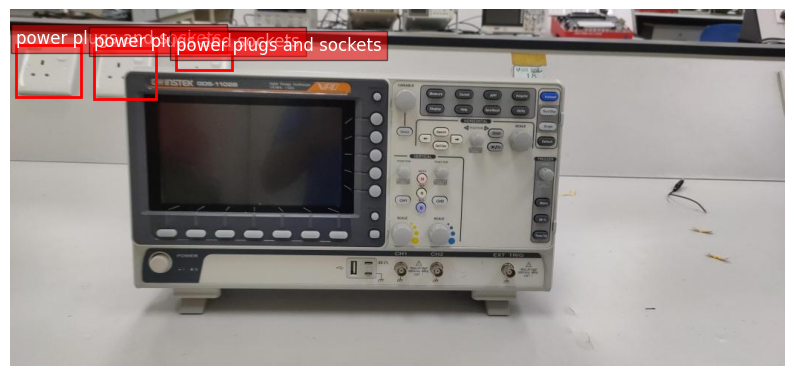

{'<OD>': {'bboxes': [[7.822499752044678,
    47.279998779296875,
    94.39149475097656,
    117.36000061035156],
   [113.16549682617188, 51.119998931884766, 195.5625, 119.75999450683594],
   [222.6804962158203,
    56.39999771118164,
    297.7764892578125,
    80.87999725341797]],
  'labels': ['power plugs and sockets',
   'power plugs and sockets',
   'power plugs and sockets']}}

In [13]:
import matplotlib.pyplot as plt

def plot_bboxes_on_image(image, bboxes, labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    ax = plt.gca()
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin - 2, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()




def florence2_inference_results(model, dataset: DetectionDataset, count: int):
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        #inputs = processor(text=prompt, images=image, return_tensors="pt")

        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task='<OD>',
            image_size=(image.width, image.height))
        # Access bounding boxes and labels
        od_results = parsed_answer['<OD>']
        bboxes = od_results['bboxes']
        labels = od_results['labels']

        # Plot bounding boxes on the image using the separate function
        plot_bboxes_on_image(image, bboxes, labels)
    return parsed_answer


florence2_inference_results(peft_model, val_dataset, 1)

In [14]:
# training loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    #florence2_inference_results(peft_model, val_loader.dataset, 3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            florence2_inference_results(peft_model, val_loader.dataset, 2)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [15]:
#  Training

EPOCHS = 1
LR = 4e-6
train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
Training Epoch 1/1:   0%|          | 0/17 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 244.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3133 has 14.74 GiB memory in use. Of the allocated memory 14.55 GiB is allocated by PyTorch, and 64.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)